<a href="https://colab.research.google.com/github/siddhant012/Open-AI-Gym-colab/blob/main/gym_test_CartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

import gym
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(200, 150))
display.start()

from pyvirtualdisplay import Display
display = Display(visible=0, size=(200, 150))
display.start()

In [ ]:
import numpy as np
import random
import math
#import gym
from tensorflow import keras

In [ ]:
def render(env_obj):
    screen=env_obj.render(mode='rgb_array')
    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

def load(env_name):
    env_obj=gym.make(env_name)
    return env_obj

def reset(env_obj):
    state=env_obj.reset()
    prev_screen = env_obj.render(mode='rgb_array')
    plt.imshow(prev_screen)
    return state

def close(env_obj):
    ipythondisplay.clear_output(wait=True)
    env_obj.close()

In [ ]:
class PolicyNet:

    def __init__(self,load_name="",save_name=""):

        self.load_name=load_name
        self.save_name=save_name
        self.learning_rate=0.01
        self.loss="mse"
    
    def build_model(self,input_shape,output_shape,learning_rate=0.01,loss="mse"):
        self.learning_rate=learning_rate
        self.loss=loss

        if(len(self.load_name)>0):
            self.model=keras.models.load_model(self.load_name)
        else:
            self.model=keras.Sequential()
            self.model.add(keras.layers.Dense(50,input_shape=input_shape,activation="relu"))
            self.model.add(keras.layers.Dense(50,activation="relu"))
            self.model.add(keras.layers.Dense(units=output_shape,activation="linear"))

            self.model.compile(optimizer=keras.optimizers.Adam(lr=self.learning_rate),loss=self.loss)

        return self.model

    def preprocess_inputs(self,inputs):
        return inputs

    def get_model(self):
        return self.model
    
    def get_model_weights(self):
        return self.model.get_weights()

    def get_hyperparameters(self):
        return dict([('learning_rate',self.learning_rate),('loss',self.loss)])

    def save_model(self):
        if(len(self.save_name)>0) : self.model.save(self.save_name)
    
    def train_model(self,inputs,outputs):
        inputs=self.preprocess_inputs(inputs)
        self.model.fit(inputs.astype(np.float32),outputs.astype(np.float32),epochs=1,batch_size=1,verbose=0,shuffle=False)
    
    def get_Qvals(self,inputs):
        inputs=self.preprocess_inputs(inputs)
        Qvals=self.model.predict(inputs.astype(np.float32))
        return Qvals
    
    def get_policy_from_Qvals(self,Qvals):
        return np.exp(Qvals) / np.sum(np.exp(Qvals), axis=0)

class TargetNet:

    def __init__(self,policy_net,target_update=10):
        self.policy_net=policy_net
        self.target_update=target_update
    
    def build_model(self):
        self.model=keras.models.clone_model(self.policy_net.model)
        hyperparameters=self.policy_net.get_hyperparameters()
        learning_rate=hyperparameters['learning_rate']
        loss=hyperparameters['loss']

        self.model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate),loss=loss)
        return self.model

    def set_model_weights(self):
        self.model.set_weights(self.policy_net.get_model_weights())

    def get_target_Qvals(self,inputs,step):
        if(step%self.target_update==0) : self.set_model_weights()
        inputs=self.policy_net.preprocess_inputs(inputs)
        return self.model.predict(inputs.astype(np.float32))


class ReplayMemory:
    def __init__(self,capacity,batch_size):
        self.capacity=capacity
        self.batch_size=batch_size
        self.memory=[]
        self.push_count=0

    def push(self,experience):
        if(len(self.memory)<self.capacity):
            self.memory.append(experience)
        else:
            self.memory[self.push_count%self.capacity]=experience
        self.push_count+=1
    
    def sample(self):
        return random.sample(self.memory,self.batch_size)
    
    def can_provide_sample(self):
        return len(self.memory)>=self.batch_size



class ExploreExploitStrat:
    def __init__(self,strategy):
        self.strategy=strategy

    def get_exploration_rate(self,current_step):
        return self.strategy.get_exploration_rate(current_step)

class EpsilonGreedyStrategy:
    def __init__(self,start,end,decay_rate):
        self.start=start
        self.end=end
        self.decay_rate=decay_rate

    def get_exploration_rate(self,current_step):
        return self.end + (self.start-self.end)*math.exp(-1*current_step*self.decay_rate)


class ReturnStrat:
    def __init__(self,strategy):
        self.strategy=strategy

    def get_return(self,rewards,next_Qvals,dones,current_step):
        return self.strategy.get_return(rewards,next_Qvals,dones,current_step)

class DiscountedReturn:
    def __init__(self,Y=0.5):
        self.Y=Y

    def get_return(self,rewards,next_Qvals,dones,current_step):
        return rewards+(1-dones)*self.Y*next_Qvals






class Environment:
    
    def __init__(self,env_name):
        self.env_name=env_name

        self.state=None
        self.done=None

        self.env_obj=None
        self.actions_num=None
        self.state_shape=None

    def reset(self):
        self.state=reset(self.env_obj)
        '''self.state=self.env_obj.reset()
        prev_screen = self.env_obj.render(mode='rgb_array')
        plt.imshow(prev_screen)'''
        if(not self.state_shape) : self.state_shape=self.state.shape
        self.done=False

    def load(self):
        self.env_obj=load(self.env_name)
        #self.env_obj=gym.make(self.env_name)
        if(not self.actions_num) : self.actions_num=self.env_obj.action_space.n

    def close(self):
        close(self.env_obj)
        #self.env_obj.close()
    
    def render(self):
        render(self.env_obj)
        '''screen=self.env_obj.render(mode='rgb_array')
        plt.imshow(screen)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())'''

    def change(self,action):
        if(self.done) : self.reset()
        self.state,reward,self.done,info=self.env_obj.step(action)
        return reward

class EnvManager:
    
    def __init__(self,env):
        self.env=env
        
    def reset(self):
        self.env.reset()
    
    def load(self):
        self.env.load()

    def close(self):
        self.env.close()

    def render(self):
        self.env.render()

    def get_actions_num(self):
        return self.env.actions_num
    
    def get_observation_shape(self):
        return self.env.state_shape

    def get_current_observation(self):
        return self.env.state
    
    def change(self,action):
        reward = self.env.change(action)
        next_state,done = self.env.state,self.env.done
        reward = next_state[0] + 0.5
        if(next_state[0]>=0.5) : reward+=10

        next_observation=next_state
        next_observation=self.preprocess(next_observation)
        return next_observation,reward,done

    def preprocess(self,state):
        return state
    



class Agent:

    def __init__(self,env_manager,replay_mem,explore_exploit_strat,return_strat,policy_net,target_net):
        self.env_manager=env_manager
        self.replay_mem=replay_mem
        self.explore_exploit_strat=explore_exploit_strat
        self.return_strat=return_strat
        self.policy_net=policy_net
        self.target_net=target_net

        self.action_approach="deterministic"

    def choose_action(self,policy):
        if(self.action_approach=="deterministic"):
            action=np.argmax(policy,axis=0)
        elif(self.action_approach=="stochastic"):
            action=np.random.choice(self.env_manager.get_actions_num(),p=policy)
        return action


    def take_action(self,current_step):

        observation=self.env_manager.get_current_observation()
        exploration_rate=self.explore_exploit_strat.get_exploration_rate(current_step)
        if(random.random()<exploration_rate) :  
            action=random.randrange(self.env_manager.get_actions_num())
        else : 
            curr_Qvals=self.policy_net.get_Qvals(np.expand_dims(observation,axis=0))
            curr_policy=self.policy_net.get_policy_from_Qvals(np.squeeze(curr_Qvals))
            action=self.choose_action(curr_policy)

        next_observation,reward,done=self.env_manager.change(action)
        experience=(observation,action,next_observation,reward,done)

        return experience

    def learn(self,experience,current_step):
        self.replay_mem.push(experience)

        if(self.replay_mem.can_provide_sample()):
            samples=self.replay_mem.sample()
            observations,actions,next_observations,rewards,dones = np.array(samples).T
                    
            observations=np.stack(observations,axis=0)
            actions=np.array(actions,dtype=np.int32)
            next_observations=np.stack(next_observations,axis=0)
            rewards=np.array(rewards,dtype=np.float32)
            dones=np.array(dones,dtype=np.int32)

            curr_Qvals=self.policy_net.get_Qvals(observations)
            next_Qvals=self.target_net.get_target_Qvals(next_observations,current_step)
            returns=self.return_strat.get_return(rewards, (np.take_along_axis(next_Qvals,actions[:,None],axis=1)).ravel() ,dones,current_step)
            target_Qvals=np.copy(curr_Qvals)
            np.put_along_axis(target_Qvals , actions[:,None] , returns[:,None] , axis=1)
            
            self.policy_net.train_model(observations,target_Qvals)



class RL:

    def __init__(self,agent,environment,env_manager,episodes_num=100,steps_per_episode=200):
        self.agent=agent
        self.environment=environment
        self.env_manager=env_manager

        self.episodes_num=episodes_num
        self.steps_per_episode=steps_per_episode

        self.render=False
        self.display=True

        self.logs=None
    
    def reset_logs(self):
        self.logs=dict({'episode':0,'step':0,'durations':[],'rewards':[],'exploration_rate':self.agent.explore_exploit_strat.get_exploration_rate(0)})

    def update_logs(self,experience,counter,ep,step):
        self.logs['episode']=ep
        self.logs['step']=step
        if(len(self.logs['durations'])<ep) : self.logs['durations'].append(step)
        else :  self.logs['durations'][ep-1]=step
        if(len(self.logs['rewards'])<ep) : self.logs['rewards'].append(experience[3])
        else :  self.logs['rewards'][ep-1]+=experience[3]

        self.logs['exploration_rate']=self.agent.explore_exploit_strat.get_exploration_rate(counter)

    def display_stats(self,experience,mode):
        if(mode=="train"):
            print("\n")
            print("step:",self.logs['durations'][-1])
            print("exploration_rate:",self.logs['exploration_rate'])
            Qvals=self.agent.policy_net.get_Qvals(np.expand_dims(experience[0],axis=0))
            print("reward:",experience[4])
            print("policy:",self.agent.policy_net.get_policy_from_Qvals(np.squeeze(Qvals)))
            print("action:",experience[1])
        elif(mode=="test"):
            print("\n")
            print("step:",self.logs['durations'][-1])
            Qvals=self.agent.policy_net.get_Qvals(np.expand_dims(experience[0],axis=0))
            print("reward:",experience[4])
            print("policy:",self.agent.policy_net.get_policy_from_Qvals(np.squeeze(Qvals)))
            print("action:",experience[1])


    
    def start_train(self):
        self.reset_logs()

        self.env_manager.load()
        counter=0
        for ep in range(1,self.episodes_num+1):
            self.env_manager.reset()
            print("\n\n\n\nEpisode:",ep)

            step=0
            while(1):
                step+=1;counter+=1
                if(self.render) : env_manager.render()

                experience=agent.take_action(counter)

                self.update_logs(experience,counter,ep,step)
                if(self.display) : self.display_stats(experience,mode="train")
                if(step==self.steps_per_episode or experience[4]==1):
                    print("\nEpisode finished after {} timesteps".format(step))
                    print("Total rewards in the episode:",self.logs['rewards'][-1])
                    if(len(self.logs['durations'])>100) : print("Last 100 episodes durations moving avg:",np.mean(np.array(self.logs['durations'][-100:])))
                    if(len(self.logs['rewards'])>100) : print("Last 100 episodes rewards moving avg:",np.mean(np.array(self.logs['rewards'][-100:])))
                    break

                agent.learn(experience,counter)

        env_manager.close()
        self.agent.policy_net.save_model()

    def start_test(self,episodes_num=10):
        self.reset_logs()

        self.env_manager.load()
        counter=0
        for ep in range(1,episodes_num+1):
            self.env_manager.reset()
            print("\n\n\n\nEpisode:",ep)

            step=0
            while(1):
                step+=1;counter+=1
                if(self.render) : env_manager.render()

                experience=agent.take_action(10**10)

                self.update_logs(experience,counter,ep,step)
                if(self.display) : self.display_stats(experience,mode="test")
                if(step==self.steps_per_episode or experience[4]==1):
                    print("\nEpisode finished after {} timesteps".format(step))
                    print("Total rewards in the episode:",self.logs['rewards'][-1])
                    if(len(self.logs['durations'])>100) : print("Last 100 episodes durations moving avg:",np.mean(np.array(self.logs['durations'][-100:])))
                    if(len(self.logs['rewards'])>100) : print("Last 100 episodes rewards moving avg:",np.mean(np.array(self.logs['rewards'][-100:])))
                    break
        env_manager.close()



In [ ]:
environment=Environment(env_name='CartPole-v0')
env_manager=EnvManager(environment)

policy_net=PolicyNet( load_name="",save_name="" )
policy_net.build_model(input_shape=(4,),output_shape=2,loss="mse",learning_rate=0.001)
target_net=TargetNet(policy_net=policy_net,target_update=10)
target_net.build_model()

replay_mem=ReplayMemory(capacity=100000,batch_size=32)
explore_exploit_strat=ExploreExploitStrat( strategy=EpsilonGreedyStrategy(start=1.0,end=0.1,decay_rate=0.0005) )
return_strat=ReturnStrat( strategy=DiscountedReturn(Y=0.99) )

agent=Agent(env_manager,replay_mem,explore_exploit_strat,return_strat,policy_net,target_net)

rl=RL(agent,environment,env_manager,episodes_num=5,steps_per_episode=200)
rl.display=False
rl.render=True

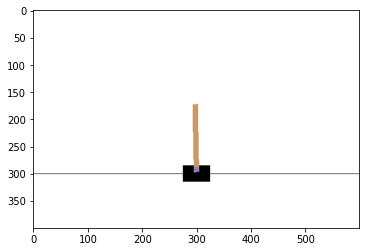

In [ ]:
rl.start_train()

KeyboardInterrupt: ignored

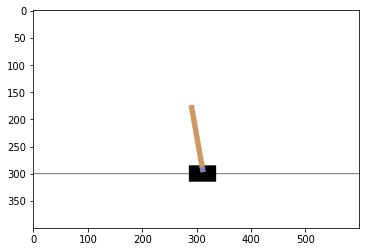

In [ ]:
rl.start_test(episodes_num=10)